In [21]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce
import re
from imblearn.ensemble import BalancedRandomForestClassifier
import os.path

dosTPath = "../../../../../dosT/ffunes/"

%matplotlib inline

sns.set_theme()

# Oslom parse

In [33]:
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    #clusters = {}
    #hashtag_clusters = {}
    data = []
    
    clusters = []
    
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                
                clusters.append(cluster)
                #clusters[cluster] = l
                for i in l:
                    #if not i in hashtag_clusters:
                    #    hashtag_clusters[i] = set()
                    #hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["id", "cluster"]), clusters

In [32]:
def extract_all_oslom(folder):
    basename = 'tp'
    
    all_clusters = {}
    
    train, clusters = extract_oslom(folder + basename)
    
    all_clusters[0] = clusters
    
    train = train.groupby(
        ["id"]
    )['cluster'].apply(list).reset_index(name='clusters')
    
    level = 1
    
    while os.path.isfile(folder + basename + str(level)):
        l_train, l_clusters = extract_oslom(folder + basename + str(level))
        
        l_train = l_train.groupby(
            ["id"]
        )['cluster'].apply(list).reset_index(name='clusters_' + str(level))
        
        train = pd.merge(
            left=train,
            right=l_train,
            how='left',
            validate='1:1'
        )
        
        all_clusters[level] = l_clusters
        
        level += 1
    
    return train, all_clusters

# Función para calcular distancias entre datos predecidos y reales

In [3]:
geonames = pd.read_pickle(dosTPath + "geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place):
    dif_distance = get_difference_distance(pred_place, real_place)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1
    
    return total_positives / len(dif_distance)

In [4]:
users_with_mentions = pd.read_pickle(dosTPath + "users_with_mentions_popular.pkl")
users_with_mentions.head(3)

,id,place_name,place_country,latitude,longitude,users_mentioned
0,773970163502870528,guadalajara de buga,colombia,3.900890,-76.297829,NaN
1,77573705,quito,ecuador,-0.229850,-78.524948,[343818604]
2,782687718576840704,tolosa,españa,43.134838,-2.078010,"[17192256, 17192256, 17192256, 17192256, 10048..."


In [5]:
users_with_mentions["unified_place"] = users_with_mentions["place_name"] + ',' + users_with_mentions["place_country"]

In [6]:
min_determined_place = users_with_mentions.loc[:, ["id", "unified_place"]].groupby("unified_place").\
                        count().reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1200, :]
min_determined_place.shape

(23, 2)

In [7]:
users_train = pd.merge(
    left=users_with_mentions,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train.shape

(79642, 7)

In [8]:
users_train.dropna(subset=["users_mentioned"], inplace=True)
users_train.reset_index(drop=True, inplace=True)
users_train.shape

(51347, 7)

Armado de matriz de adyascencia

In [9]:
#users_train["users_mentioned"] = users_train["users_mentioned"].apply(lambda x: list(map(int, x)))

In [10]:
users_ids = users_train["id"].unique()

set_users = set(users_ids)

for x in users_train["users_mentioned"].values:
    set_users |= set(x)

mentioned_users = list(set_users.difference(set(users_ids)))

total_users = list(users_ids) + mentioned_users
len(total_users)

576576

In [11]:
#Verify order

value = True

for i in range(0, len(users_train["id"])):
    if total_users[i] != users_train["id"][i]:
        value = False

print(value)

True


In [52]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    vocabulary=total_users,
    analyzer=lambda x: x
)

vector_of_mentions = vectorizer.fit_transform(users_train["users_mentioned"]).astype(np.uint8)
vector_of_mentions

<59942x606778 sparse matrix of type '<class 'numpy.uint8'>'
	with 2279883 stored elements in Compressed Sparse Row format>

In [53]:
cx = vector_of_mentions.tocoo()
edges = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
        
    #format_str = total_users[i] + " " + total_users[j] + " " + str(v)
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [54]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_mentions_weighted.csv", header=False, index=False)

Comentions

In [14]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    #vocabulary=total_users_pop,
    analyzer=lambda x: x,
    binary=True
)

vector_of_mentions = vectorizer.fit_transform(users_train["users_mentioned"]).astype(np.uint8)
vector_of_mentions

<51347x544345 sparse matrix of type '<class 'numpy.uint8'>'
	with 1007618 stored elements in Compressed Sparse Row format>

In [15]:
vector_of_co_mentions = vector_of_mentions.dot(vector_of_mentions.T)
vector_of_co_mentions.setdiag(0, k=0)
vector_of_co_mentions

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<51347x51347 sparse matrix of type '<class 'numpy.uint8'>'
	with 2211299 stored elements in Compressed Sparse Row format>

In [16]:
cx = vector_of_co_mentions.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_co_mentions.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [17]:
len(edges)

1079976

In [18]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_comentions_weighted.csv", header=False, index=False)

# Busqueda comunidades oslom

In [55]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_dir -f ../../results/matrix/mentions/edges_mentions_weighted.csv -w -r 1 -hr 0 -seed 430430 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_mentions_weighted.csv
Weighted: yes
First Level Runs:			1
Higher Level Runs:			0
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2279877 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_mentions_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_mentions_weighted.csv_oslo_files
network:: 606776 nodes and 2.27988e+06 stubs;	 average degree = 3.75736
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 45230
iteration: 20 number of modules: 27370
collection done 


checked 0 modules 0 were found significant.  Modules to check: 27973. Percentage nodes done: 0
checked 100 modu

checked 6900 modules 5483 were found significant.  Modules to check: 21073. Percentage nodes done: 0.690075
checked 7000 modules 5557 were found significant.  Modules to check: 20973. Percentage nodes done: 0.693131
checked 7100 modules 5633 were found significant.  Modules to check: 20873. Percentage nodes done: 0.695787
checked 7200 modules 5711 were found significant.  Modules to check: 20773. Percentage nodes done: 0.697824
checked 7300 modules 5786 were found significant.  Modules to check: 20673. Percentage nodes done: 0.700768
checked 7400 modules 5851 were found significant.  Modules to check: 20573. Percentage nodes done: 0.706948
checked 7500 modules 5925 were found significant.  Modules to check: 20473. Percentage nodes done: 0.710875
checked 7600 modules 6002 were found significant.  Modules to check: 20373. Percentage nodes done: 0.714742
checked 7700 modules 6065 were found significant.  Modules to check: 20273. Percentage nodes done: 0.717444
checked 7800 modules 6129 we

checked 14500 modules 10592 were found significant.  Modules to check: 13473. Percentage nodes done: 0.848461
checked 14600 modules 10645 were found significant.  Modules to check: 13373. Percentage nodes done: 0.84966
checked 14700 modules 10702 were found significant.  Modules to check: 13273. Percentage nodes done: 0.850897
checked 14800 modules 10756 were found significant.  Modules to check: 13173. Percentage nodes done: 0.852186
checked 14900 modules 10813 were found significant.  Modules to check: 13073. Percentage nodes done: 0.853658
checked 15000 modules 10874 were found significant.  Modules to check: 12973. Percentage nodes done: 0.854968
checked 15100 modules 10931 were found significant.  Modules to check: 12873. Percentage nodes done: 0.856239
checked 15200 modules 10983 were found significant.  Modules to check: 12773. Percentage nodes done: 0.857341
checked 15300 modules 11018 were found significant.  Modules to check: 12673. Percentage nodes done: 0.858439
checked 154

checked 22000 modules 14503 were found significant.  Modules to check: 5973. Percentage nodes done: 0.943223
checked 22100 modules 14538 were found significant.  Modules to check: 5873. Percentage nodes done: 0.94436
checked 22200 modules 14570 were found significant.  Modules to check: 5773. Percentage nodes done: 0.945243
checked 22300 modules 14615 were found significant.  Modules to check: 5673. Percentage nodes done: 0.946532
checked 22400 modules 14649 were found significant.  Modules to check: 5573. Percentage nodes done: 0.947491
checked 22500 modules 14692 were found significant.  Modules to check: 5473. Percentage nodes done: 0.94849
checked 22600 modules 14748 were found significant.  Modules to check: 5373. Percentage nodes done: 0.949736
checked 22700 modules 14785 were found significant.  Modules to check: 5273. Percentage nodes done: 0.95071
checked 22800 modules 14825 were found significant.  Modules to check: 5173. Percentage nodes done: 0.951658
checked 22900 modules 

checked 3800 unions. Fused: 0
checked 3900 unions. Fused: 0
checked 4000 unions. Fused: 0
checked 4100 unions. Fused: 0
checked 4200 unions. Fused: 0
checked 4300 unions. Fused: 0
checked 4400 unions. Fused: 0
checked 4500 unions. Fused: 0
checked 4600 unions. Fused: 0
checked 4700 unions. Fused: 0
checked 4800 unions. Fused: 0
checked 4900 unions. Fused: 0
checked 5000 unions. Fused: 0
checked 5400 unions. Fused: 0
checked 5500 unions. Fused: 0
checked 5700 unions. Fused: 0
checked 5800 unions. Fused: 0
checked 5900 unions. Fused: 0
checked 6000 unions. Fused: 0
checked 6400 unions. Fused: 0
checked 6500 unions. Fused: 0
checked 6600 unions. Fused: 0
checked 6700 unions. Fused: 0
checked 6900 unions. Fused: 0
checked 7000 unions. Fused: 0
checked 7900 unions. Fused: 0
checked 8000 unions. Fused: 0
checked 8200 unions. Fused: 0
checked 8300 unions. Fused: 0
checked 8400 unions. Fused: 0
checked 8600 unions. Fused: 0
checked 8700 unions. Fused: 0
checked 8800 unions. Fused: 0
checked 89

In [20]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_comentions_weighted.csv -w -r 1 -hr 1 -seed 430430 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_comentions_weighted.csv
Weighted: yes
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2159952 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_comentions_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_comentions_weighted.csv_oslo_files
network:: 43193 nodes and 2.15995e+06 stubs;	 average degree = 50.007
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 8204
iteration: 20 number of modules: 1600
collection done 


checked 0 modules 0 were found significant.  Modules to check: 1648. Percentage nodes done: 0
checked 100 mod

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 143
collection done 


possible fusions to check: 134
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/matrix/mentions/edges_comentions_weighted.csv_oslo_files/partitions_level_2
2 groups found
2 bss found
checking homeless nodes
writing final solution in file ../../results/matrix/mentions/edges_comentions_weighted.csv_oslo_files/short_tp2
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
network:: 194 

# Predicciones

In [34]:
train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_comentions_weighted.csv_oslo_files/')

In [39]:
train.head(2)

,id,clusters,clusters_1,clusters_2,clusters_3
0,77573705,[844],[171],"[0, 1]",[0]
1,2322810141,[844],[171],"[0, 1]",[0]


In [37]:
def get_original_user_id(row):
    return total_users[row["id"]]

train["id"] = train.apply(get_original_user_id, axis=1)

In [40]:
users_train_final = pd.merge(
    left=train,
    right=users_train,
    how='inner',
    left_on="id",
    right_on="id",
    validate="m:1"
)

In [42]:
users_train_final.shape

(43193, 11)

In [43]:
users_train_final.head()

,id,clusters,clusters_1,clusters_2,clusters_3,place_name,place_country,latitude,longitude,users_mentioned,unified_place
0,77573705,[844],[171],"[0, 1]",[0],quito,ecuador,-0.22985,-78.524948,[343818604],"quito,ecuador"
1,2322810141,[844],[171],"[0, 1]",[0],quito,ecuador,-0.22985,-78.524948,[816840259],"quito,ecuador"
2,298297565,[844],[171],"[0, 1]",[0],quito,ecuador,-0.22985,-78.524948,"[19195936, 65056859, 413482537, 600869268]","quito,ecuador"
3,541257350,[844],[171],"[0, 1]",[0],quito,ecuador,-0.22985,-78.524948,"[929802063382446083, 929802063382446083, 92980...","quito,ecuador"
4,332466120,[206],[171],"[0, 1]",[0],quito,ecuador,-0.22985,-78.524948,"[3273892892, 172127139]","quito,ecuador"


In [44]:
locations = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [47]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    analyzer=lambda x: x
)

vector_of_clusters_0 = vectorizer.fit_transform(users_train_final["clusters"]).astype(np.float32)
vector_of_clusters_0

<43193x1439 sparse matrix of type '<class 'numpy.float32'>'
	with 46284 stored elements in Compressed Sparse Row format>

In [48]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    analyzer=lambda x: x
)

vector_of_clusters_1 = vectorizer.fit_transform(users_train_final["clusters_1"]).astype(np.float32)
vector_of_clusters_1

<43193x320 sparse matrix of type '<class 'numpy.float32'>'
	with 50833 stored elements in Compressed Sparse Row format>

In [49]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    analyzer=lambda x: x
)

vector_of_clusters_2 = vectorizer.fit_transform(users_train_final["clusters_2"]).astype(np.float32)
vector_of_clusters_2

<43193x194 sparse matrix of type '<class 'numpy.float32'>'
	with 69486 stored elements in Compressed Sparse Row format>

In [50]:
vectorizer = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    analyzer=lambda x: x
)

vector_of_clusters_3 = vectorizer.fit_transform(users_train_final["clusters_3"]).astype(np.float32)
vector_of_clusters_3

<43193x188 sparse matrix of type '<class 'numpy.float32'>'
	with 43279 stored elements in Compressed Sparse Row format>

In [67]:
estimators = [
    {
        "name": "LightGBM",
        "estimator": lgb.LGBMClassifier(n_jobs=1, objective="multiclass", random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, -1], 'class_weight': ['balanced']}
    },    
    {
        "name": "SVC",
        "estimator": SVC(kernel="rbf", probability=True, random_state=1500),
        "params_grid": {"C": [1, 10, 100], "gamma": [.01, .1], 'class_weight': ['balanced']}
    },
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(n_jobs=-1, random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'max_features': ['sqrt', 5, 8, 200], 'class_weight': ['balanced_subsample']}
    }
]

In [51]:
estimators = [
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    }
]

In [52]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [65]:
scores = {}
predictions = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    nested_score = cross_validate(
        clf,
        X=vector_of_clusters_0,
        y=locations[:,0],
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    nested_predict = cross_val_predict(
        clf,
        X=vector_of_clusters_0,
        y=locations[:,0],
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
        
    scores[estimator["name"]] = nested_score
    predictions[estimator["name"]] = nested_predict

In [66]:
scores

{'DecisionTree': {'fit_time': array([10.89079356, 10.89443636, 10.92099619, 10.36468244, 11.01821685]),
  'score_time': array([6.76014996, 5.34597635, 6.93277526, 6.96678424, 6.16623807]),
  'test_accuracy': array([0.50364626, 0.2811668 , 0.48859822, 0.50081037, 0.50567261]),
  'test_balanced_accuracy': array([0.42025497, 0.42531993, 0.41391222, 0.42850383, 0.41699411]),
  'test_roc_auc_ovo': array([0.84089455, 0.840622  , 0.83672044, 0.8435125 , 0.8382986 ]),
  'test_accuracy@161': array([0.65377937, 0.67554115, 0.64903345, 0.65061357, 0.66936791])}}

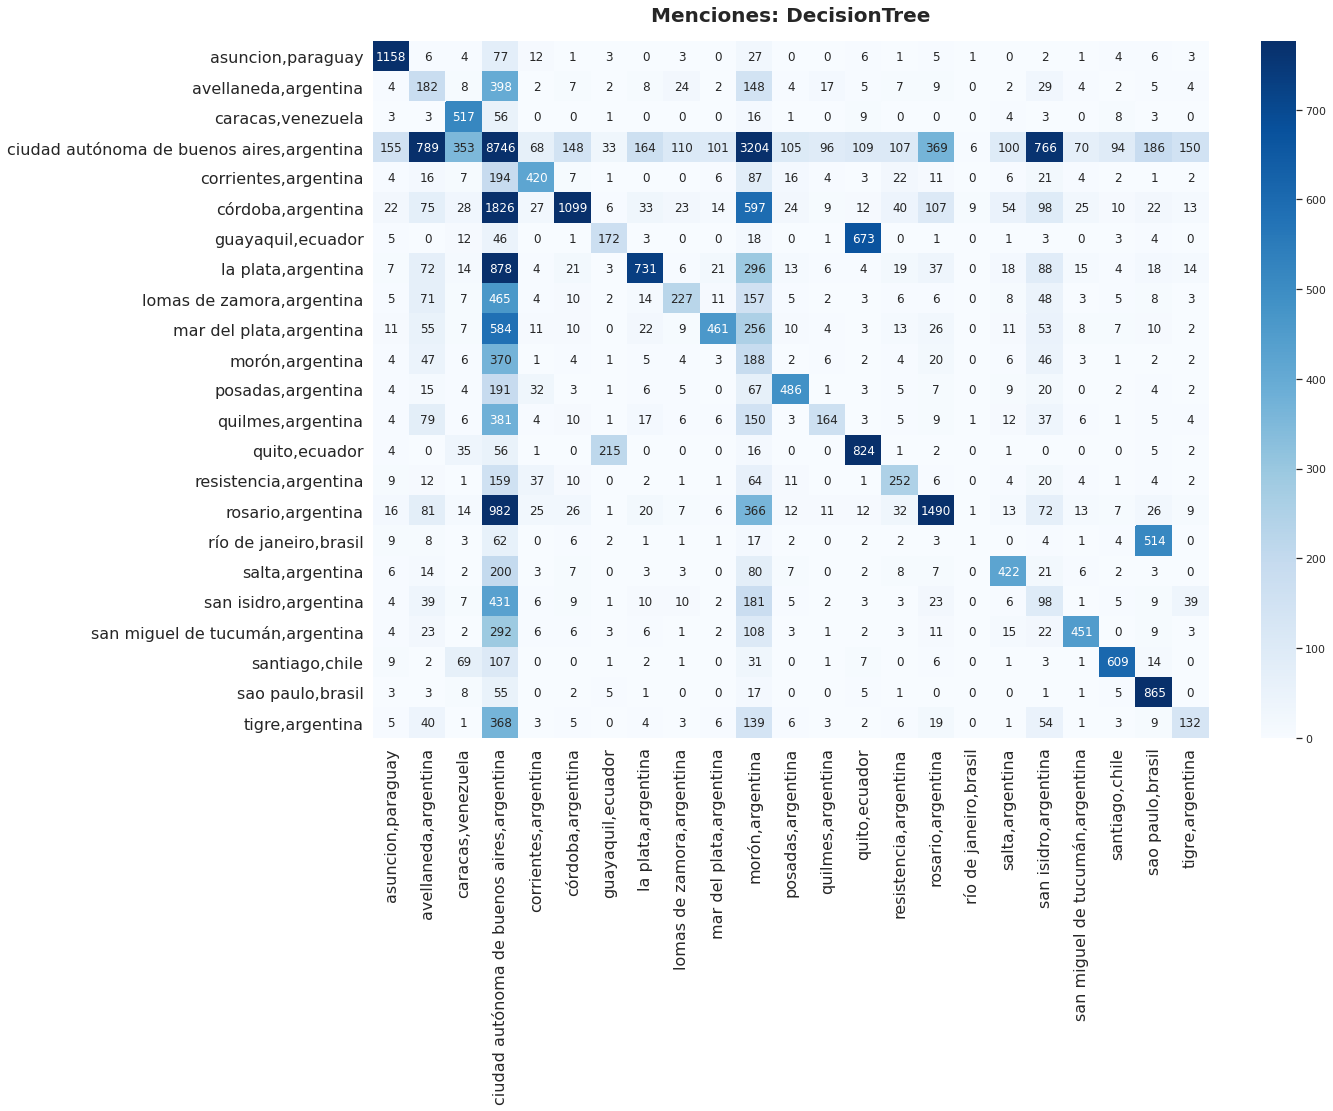

In [67]:
f, ax = plt.subplots(nrows=len(predictions), figsize=(25, 20*len(predictions)))
i = 0
f.tight_layout(pad=30.0)

for key in predictions:
    cm = confusion_matrix(locations[:,0], predictions[key], labels=class_names)

    sns.heatmap(
        cm,
        annot=True,
        #linewidths=.5,
        fmt='d',
        robust=True,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax
    )
    
    ax.set_title("Menciones: " + key, fontsize=20, fontweight='bold', pad=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    i += 1

In [130]:
estimators = [
    {
        "name": "BalRandomForest",
        "estimator": BalancedRandomForestClassifier(n_jobs=-1, random_state=42),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'max_features': ['sqrt'], 'sampling_strategy': ["all"]}
    }
]

In [131]:
scores = {}
predictions = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    nested_score = cross_validate(
        clf,
        X=vector_of_clusters,
        y=locations[:,0],
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    print(nested_score)
        
    nested_predict = cross_val_predict(
        clf,
        X=vector_of_clusters,
        y=locations[:,0],
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
        
    scores[estimator["name"]] = nested_score
    predictions[estimator["name"]] = nested_predict

{'fit_time': array([88.95833564, 88.6964035 , 91.20828176, 89.87744808, 88.86435628]), 'score_time': array([10.12071991,  9.41216445,  8.07217002,  7.8391397 ,  7.975703  ]), 'test_accuracy': array([0.39402709, 0.37863179, 0.39541614, 0.37855985, 0.39592498]), 'test_balanced_accuracy': array([0.44068706, 0.4368767 , 0.44907761, 0.44200685, 0.44360486]), 'test_roc_auc_ovo': array([0.8586104 , 0.85852354, 0.86504953, 0.860095  , 0.85960224]), 'test_accuracy@161': array([0.62912374, 0.61210788, 0.62738743, 0.61646214, 0.62317666])}


In [133]:
scores

{'BalRandomForest': {'fit_time': array([88.95833564, 88.6964035 , 91.20828176, 89.87744808, 88.86435628]),
  'score_time': array([10.12071991,  9.41216445,  8.07217002,  7.8391397 ,  7.975703  ]),
  'test_accuracy': array([0.39402709, 0.37863179, 0.39541614, 0.37855985, 0.39592498]),
  'test_balanced_accuracy': array([0.44068706, 0.4368767 , 0.44907761, 0.44200685, 0.44360486]),
  'test_roc_auc_ovo': array([0.8586104 , 0.85852354, 0.86504953, 0.860095  , 0.85960224]),
  'test_accuracy@161': array([0.62912374, 0.61210788, 0.62738743, 0.61646214, 0.62317666])}}

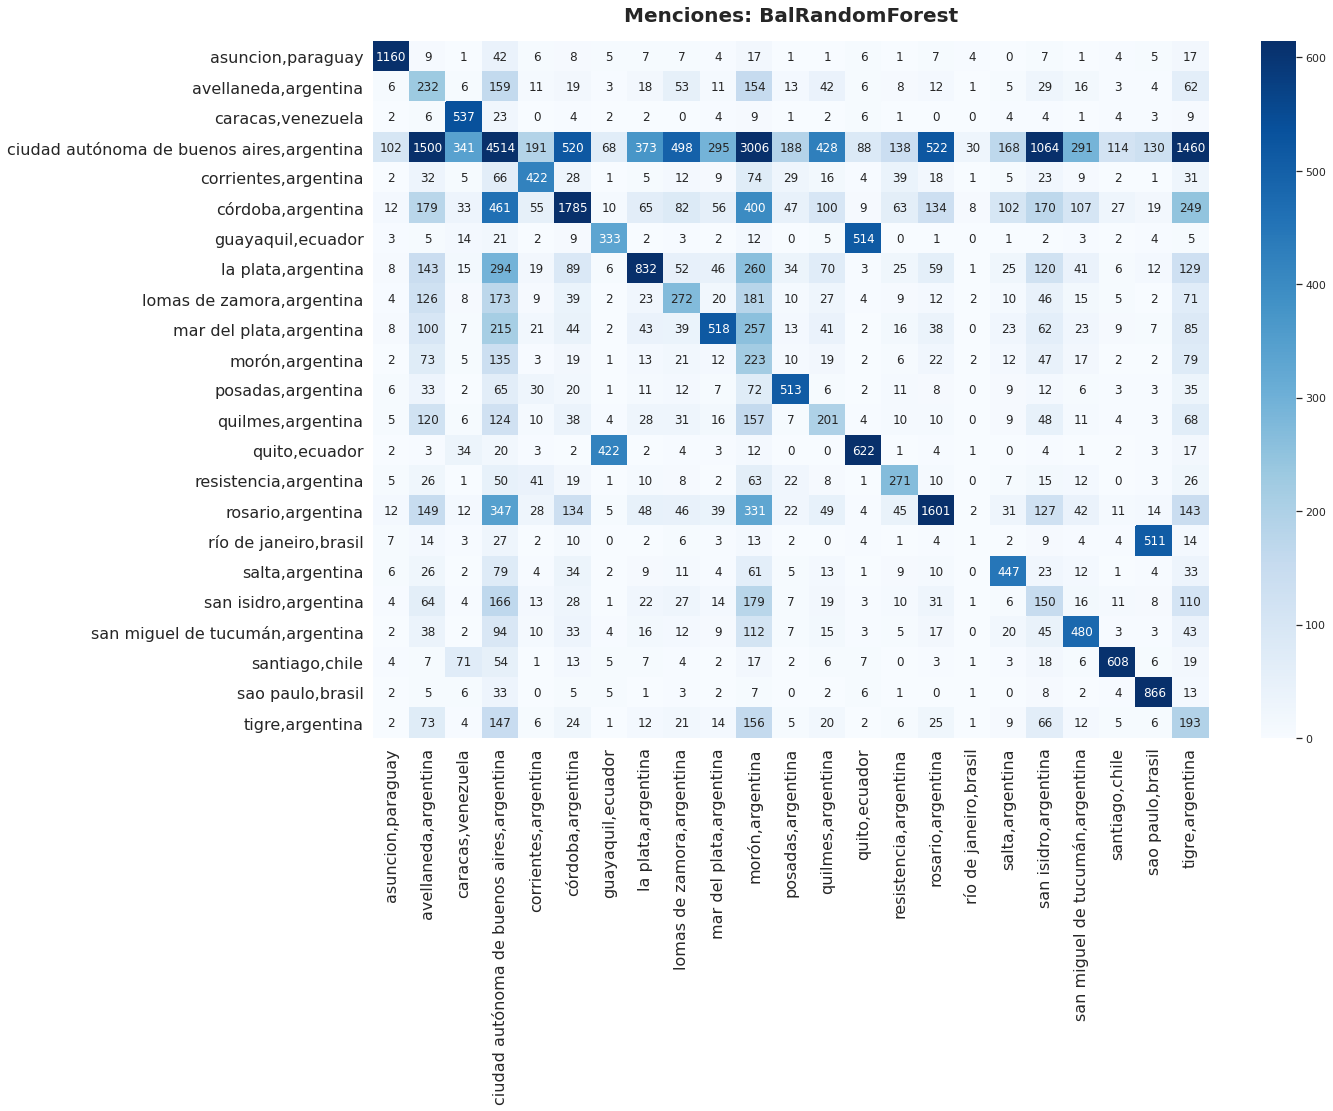

In [132]:
f, ax = plt.subplots(nrows=len(predictions), figsize=(25, 20*len(predictions)))
i = 0
f.tight_layout(pad=30.0)

for key in predictions:
    cm = confusion_matrix(locations[:,0], predictions[key], labels=class_names)

    sns.heatmap(
        cm,
        annot=True,
        #linewidths=.5,
        fmt='d',
        robust=True,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax
    )
    
    ax.set_title("Menciones: " + key, fontsize=20, fontweight='bold', pad=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    i += 1